In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, ExtraTreesRegressor
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.impute import SimpleImputer
import warnings
warnings.filterwarnings('ignore')

plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

In [6]:
def load_data():
    df = pd.read_csv('../SeoulBikeData.csv', encoding='latin1')
    df.columns = df.columns.str.strip()
    df = df.rename(columns={
        'Date': 'date',
        'Rented Bike Count': 'rented_bike_count',
        'Hour': 'hour',
        'Temperature(°C)': 'temperature_c',
        'Humidity(%)': 'humidity',
        'Wind speed (m/s)': 'wind_speed',
        'Visibility (10m)': 'visibility_10m',
        'Dew point temperature(°C)': 'dew_point_c',
        'Solar Radiation (MJ/m2)': 'solar_radiation',
        'Rainfall(mm)': 'rainfall_mm',
        'Snowfall (cm)': 'snowfall_cm',
        'Seasons': 'season',
        'Holiday': 'holiday',
        'Functioning Day': 'functioning_day'
    })
    
    return df

In [ ]:
df = load_data()
print(f"Dataset shape: {df.shape}")
df.head()

Dataset shape: (8760, 14)

First few rows:


,date,rented_bike_count,hour,temperature_c,humidity,wind_speed,visibility_10m,dew_point_c,solar_radiation,rainfall_mm,snowfall_cm,season,holiday,functioning_day
0,01/12/2017,254,0,-5.2,37,2.2,2000,-17.6,0.0,0.0,0.0,Winter,No Holiday,Yes
1,01/12/2017,204,1,-5.5,38,0.8,2000,-17.6,0.0,0.0,0.0,Winter,No Holiday,Yes
2,01/12/2017,173,2,-6.0,39,1.0,2000,-17.7,0.0,0.0,0.0,Winter,No Holiday,Yes
3,01/12/2017,107,3,-6.2,40,0.9,2000,-17.6,0.0,0.0,0.0,Winter,No Holiday,Yes
4,01/12/2017,78,4,-6.0,36,2.3,2000,-18.6,0.0,0.0,0.0,Winter,No Holiday,Yes


In [10]:

print("Dataset Information:")
print(df.info())
print("\nTarget variable statistics:")
print(df['rented_bike_count'].describe())



Dataset Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8760 entries, 0 to 8759
Data columns (total 14 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   date               8760 non-null   object 
 1   rented_bike_count  8760 non-null   int64  
 2   hour               8760 non-null   int64  
 3   temperature_c      8760 non-null   float64
 4   humidity           8760 non-null   int64  
 5   wind_speed         8760 non-null   float64
 6   visibility_10m     8760 non-null   int64  
 7   dew_point_c        8760 non-null   float64
 8   solar_radiation    8760 non-null   float64
 9   rainfall_mm        8760 non-null   float64
 10  snowfall_cm        8760 non-null   float64
 11  season             8760 non-null   object 
 12  holiday            8760 non-null   object 
 13  functioning_day    8760 non-null   object 
dtypes: float64(6), int64(4), object(4)
memory usage: 958.2+ KB
None

Target variable statistics:
count 

In [11]:
df.isnull().sum()


Missing values:
date                 0
rented_bike_count    0
hour                 0
temperature_c        0
humidity             0
wind_speed           0
visibility_10m       0
dew_point_c          0
solar_radiation      0
rainfall_mm          0
snowfall_cm          0
season               0
holiday              0
functioning_day      0
dtype: int64


In [12]:
def feature_engineering(df):
    df = df.copy()
    
    # Convert date to datetime
    df['date'] = pd.to_datetime(df['date'], format='%d/%m/%Y')
    
    # Extract datetime features
    df['year'] = df['date'].dt.year
    df['month'] = df['date'].dt.month
    df['day'] = df['date'].dt.day
    df['day_of_week'] = df['date'].dt.dayofweek
    df['day_name'] = df['date'].dt.day_name()
    df['is_weekend'] = df['day_of_week'].isin([5, 6]).astype(int)
    
    # Cyclical features for time
    df['hour_sin'] = np.sin(2 * np.pi * df['hour'] / 24)
    df['hour_cos'] = np.cos(2 * np.pi * df['hour'] / 24)
    df['month_sin'] = np.sin(2 * np.pi * df['month'] / 12)
    df['month_cos'] = np.cos(2 * np.pi * df['month'] / 12)
    df['day_of_week_sin'] = np.sin(2 * np.pi * df['day_of_week'] / 7)
    df['day_of_week_cos'] = np.cos(2 * np.pi * df['day_of_week'] / 7)
    
    df['time_of_day'] = pd.cut(df['hour'], 
                               bins=[0, 6, 12, 18, 24], 
                               labels=['Night', 'Morning', 'Afternoon', 'Evening'],
                               include_lowest=True)
    
    df['is_rush_hour'] = df['hour'].isin([7, 8, 9, 17, 18, 19]).astype(int)
    
    df['temp_feel'] = pd.cut(df['temperature_c'], 
                            bins=[-float('inf'), 0, 10, 20, float('inf')],
                            labels=['Very_Cold', 'Cold', 'Mild', 'Warm'])
    
    # Weather interactions
    df['temp_humidity_interaction'] = df['temperature_c'] * df['humidity'] / 100
    df['wind_rain_interaction'] = df['wind_speed'] * df['rainfall_mm']
    df['temp_solar_interaction'] = df['temperature_c'] * df['solar_radiation']
    
    # Binary weather conditions
    df['has_rain'] = (df['rainfall_mm'] > 0).astype(int)
    df['has_snow'] = (df['snowfall_cm'] > 0).astype(int)
    df['is_holiday'] = (df['holiday'] == 'Holiday').astype(int)
    df['is_functioning'] = (df['functioning_day'] == 'Yes').astype(int)
    
    # Seasonal indicators
    df['is_spring'] = (df['season'] == 'Spring').astype(int)
    df['is_summer'] = (df['season'] == 'Summer').astype(int)
    df['is_autumn'] = (df['season'] == 'Autumn').astype(int)
    df['is_winter'] = (df['season'] == 'Winter').astype(int)
    
    # Weather severity
    df['extreme_weather'] = ((df['rainfall_mm'] > 5) | 
                            (df['snowfall_cm'] > 1) | 
                            (df['wind_speed'] > 5)).astype(int)
    
    return df

In [13]:
df_features = feature_engineering(df)
print(f"Dataset shape after feature engineering: {df_features.shape}")

Dataset shape after feature engineering: (8760, 41)


In [ ]:
df_features.info()

In [14]:
def prepare_features(df):
    """Prepare features for machine learning models"""
    
    numerical_features = [
        'hour', 'temperature_c', 'humidity', 'wind_speed', 'visibility_10m',
        'dew_point_c', 'solar_radiation', 'rainfall_mm', 'snowfall_cm',
        'year', 'month', 'day_of_week', 'hour_sin', 'hour_cos',
        'month_sin', 'month_cos', 'day_of_week_sin', 'day_of_week_cos',
        'temp_humidity_interaction', 'wind_rain_interaction', 'temp_solar_interaction'
    ]
    
    binary_features = [
        'is_weekend', 'is_rush_hour', 'has_rain', 'has_snow', 
        'is_holiday', 'is_functioning', 'is_spring', 'is_summer', 
        'is_autumn', 'is_winter', 'extreme_weather'
    ]
    
    categorical_features = ['time_of_day', 'temp_feel']
    
    df_encoded = pd.get_dummies(df, columns=categorical_features, prefix=categorical_features)
    
    encoded_categorical_cols = [col for col in df_encoded.columns 
                               if any(cat in col for cat in categorical_features)]
    
    all_features = numerical_features + binary_features + encoded_categorical_cols
    
    X = df_encoded[all_features]
    y = df_encoded['rented_bike_count']
    
    return X, y, all_features

In [15]:
# Prepare features
X, y, feature_names = prepare_features(df_features)
print(f"Feature matrix shape: {X.shape}")
print(f"Target variable shape: {y.shape}")
print(f"Number of features: {len(feature_names)}")

# %%
# Split the data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=pd.cut(y, bins=5)
)

print(f"Training set size: {X_train.shape[0]}")
print(f"Test set size: {X_test.shape[0]}")
print(f"Training target range: {y_train.min():.0f} - {y_train.max():.0f}")
print(f"Test target range: {y_test.min():.0f} - {y_test.max():.0f}")


Feature matrix shape: (8760, 40)
Target variable shape: (8760,)
Number of features: 40
Training set size: 7008
Test set size: 1752
Training target range: 0 - 3556
Test target range: 0 - 3384


In [16]:
# Model evaluation function
def evaluate_model(model, X_train, X_test, y_train, y_test, model_name):
    """Evaluate a model and return comprehensive metrics"""
    # Fit the model
    model.fit(X_train, y_train)
    
    # Make predictions
    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)
    
    # Calculate metrics
    train_rmse = np.sqrt(mean_squared_error(y_train, y_pred_train))
    test_rmse = np.sqrt(mean_squared_error(y_test, y_pred_test))
    train_mae = mean_absolute_error(y_train, y_pred_train)
    test_mae = mean_absolute_error(y_test, y_pred_test)
    train_r2 = r2_score(y_train, y_pred_train)
    test_r2 = r2_score(y_test, y_pred_test)
    
    # Calculate MAPE (Mean Absolute Percentage Error)
    def mape(actual, predicted):
        return np.mean(np.abs((actual - predicted) / actual)) * 100
    
    train_mape = mape(y_train, y_pred_train)
    test_mape = mape(y_test, y_pred_test)
    
    return {
        'Model': model_name,
        'Train_RMSE': train_rmse,
        'Test_RMSE': test_rmse,
        'Train_MAE': train_mae,
        'Test_MAE': test_mae,
        'Train_R2': train_r2,
        'Test_R2': test_r2,
        'Train_MAPE': train_mape,
        'Test_MAPE': test_mape,
        'Overfitting_Score': train_rmse - test_rmse
    }


In [17]:
def get_models():
    """Get dictionary of models to evaluate"""
    models = {
        'Linear Regression': LinearRegression(),
        'Ridge Regression': Ridge(alpha=1.0, random_state=42),
        'Lasso Regression': Lasso(alpha=1.0, random_state=42),
        'Elastic Net': ElasticNet(alpha=1.0, random_state=42),
        'Decision Tree': DecisionTreeRegressor(random_state=42, max_depth=15),
        'Random Forest': RandomForestRegressor(
            n_estimators=100, random_state=42, max_depth=15, n_jobs=-1
        ),
        'Extra Trees': ExtraTreesRegressor(
            n_estimators=100, random_state=42, max_depth=15, n_jobs=-1
        ),
        'Gradient Boosting': GradientBoostingRegressor(
            n_estimators=100, random_state=42, max_depth=6
        ),
        'K-Nearest Neighbors': KNeighborsRegressor(n_neighbors=5),
        'Support Vector Regression': SVR(kernel='rbf', C=100, gamma='scale')
    }
    return models

In [18]:
def train_all_models(X_train, X_test, y_train, y_test):
    """Train and evaluate all models"""
    models = get_models()
    results = []
    trained_models = {}
    
    # Scale features for models that need it
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    scale_sensitive_models = ['Linear Regression', 'Ridge Regression', 
                             'Lasso Regression', 'Elastic Net', 
                             'K-Nearest Neighbors', 'Support Vector Regression']
    
    for name, model in models.items():
        print(f"Training {name}...")
        
        if name in scale_sensitive_models:
            # Use scaled features
            result = evaluate_model(model, X_train_scaled, X_test_scaled, 
                                  y_train, y_test, name)
            model.fit(X_train_scaled, y_train)
        else:
            # Use original features
            result = evaluate_model(model, X_train, X_test, y_train, y_test, name)
            model.fit(X_train, y_train)
        
        results.append(result)
        trained_models[name] = model
    
    return pd.DataFrame(results), trained_models, scaler

# Train all models
results_df, trained_models, scaler = train_all_models(X_train, X_test, y_train, y_test)

Training Linear Regression...
Training Ridge Regression...
Training Lasso Regression...
Training Elastic Net...
Training Decision Tree...
Training Random Forest...
Training Extra Trees...
Training Gradient Boosting...
Training K-Nearest Neighbors...
Training Support Vector Regression...


In [20]:
print("Model Performance Comparison:")
print("="*80)
results_display = results_df.round(3)
print(results_display.to_string(index=False))

Model Performance Comparison:
                    Model  Train_RMSE  Test_RMSE  Train_MAE  Test_MAE  Train_R2  Test_R2  Train_MAPE  Test_MAPE  Overfitting_Score
        Linear Regression     348.603    348.390    260.715   255.732     0.708    0.708         inf        inf              0.212
         Ridge Regression     348.603    348.418    260.712   255.766     0.708    0.708         inf        inf              0.185
         Lasso Regression     349.086    348.924    260.591   256.233     0.707    0.707         inf        inf              0.161
              Elastic Net     391.195    391.799    287.383   285.056     0.632    0.631         inf        inf             -0.604
            Decision Tree      81.123    236.840     33.811   132.688     0.984    0.865        4.64        inf           -155.718
            Random Forest      75.133    166.309     45.163    97.807     0.986    0.934         inf        inf            -91.176
              Extra Trees      48.585    156.860     

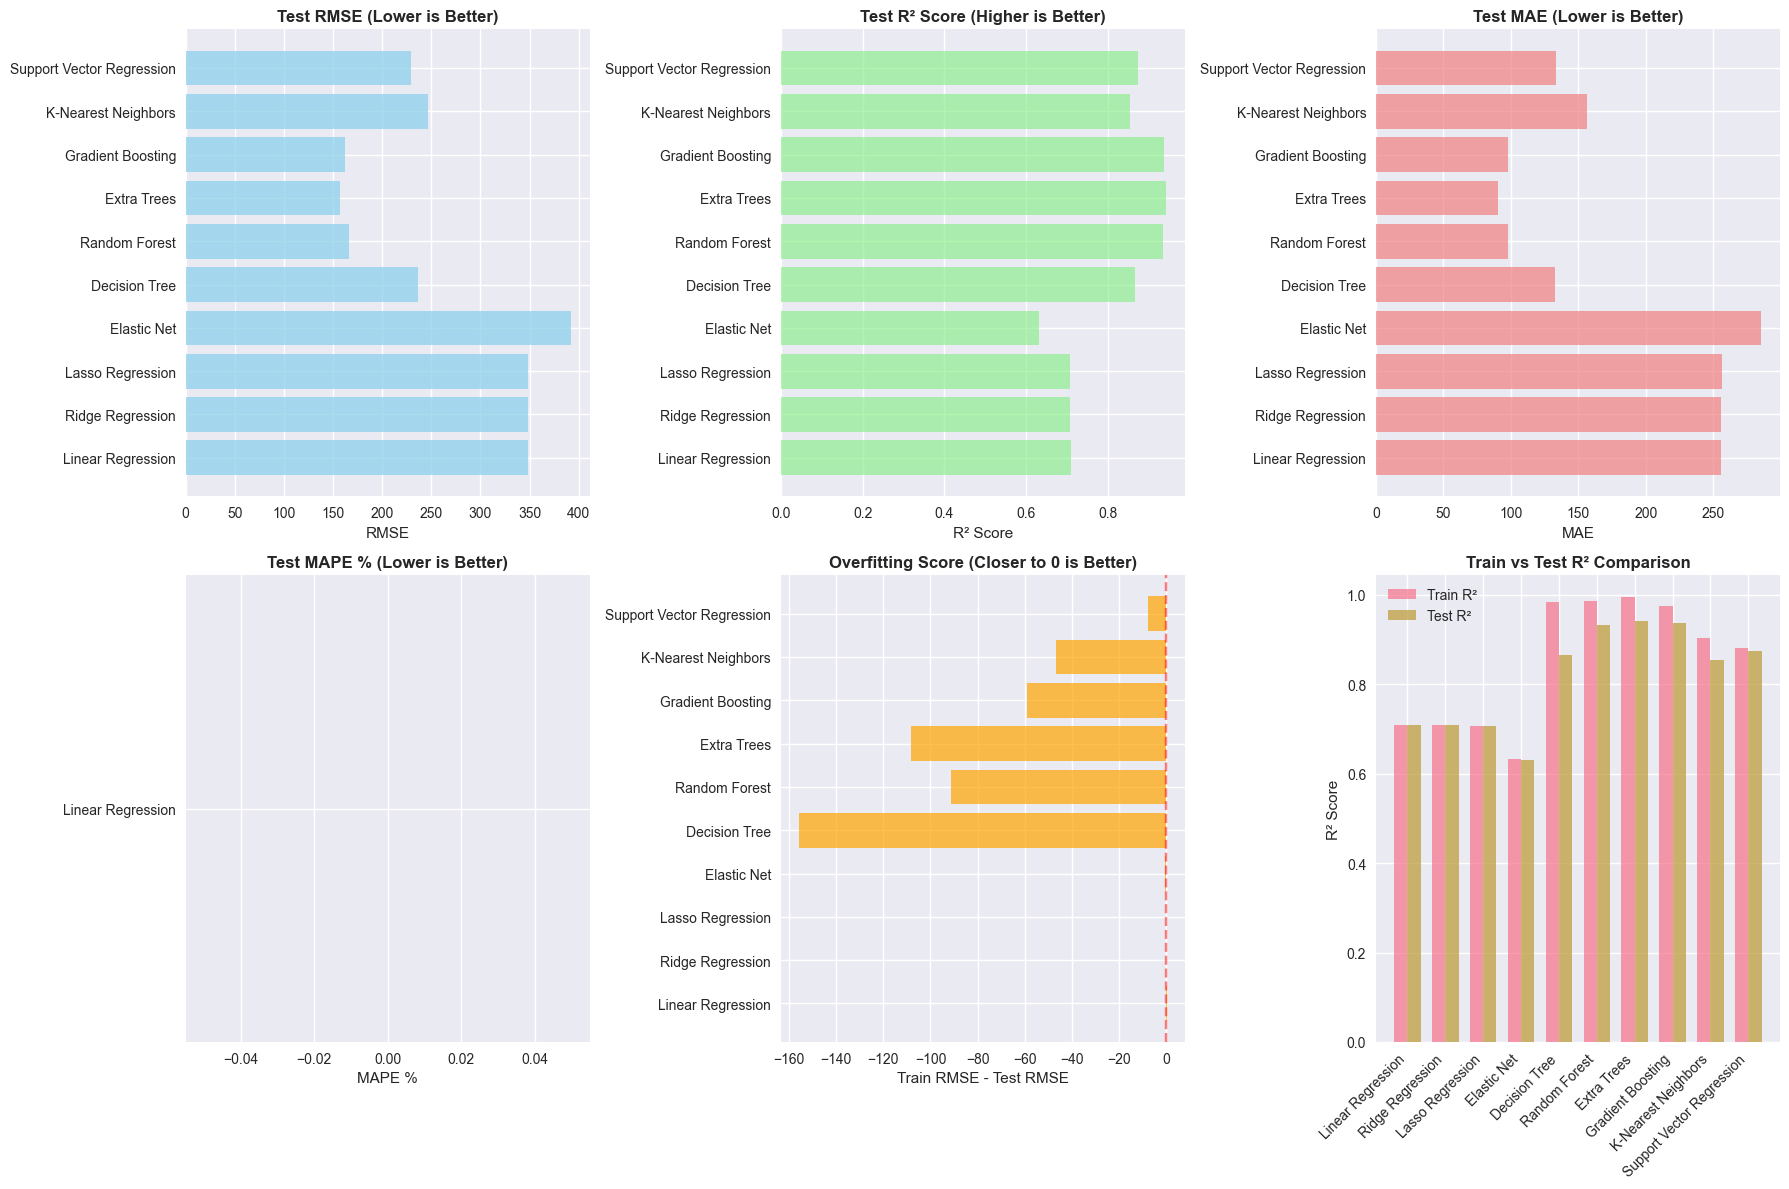

In [19]:
def plot_model_comparison(results_df):
    """Create comprehensive model comparison plots"""
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    
    # Test RMSE
    axes[0, 0].barh(results_df['Model'], results_df['Test_RMSE'], color='skyblue', alpha=0.7)
    axes[0, 0].set_title('Test RMSE (Lower is Better)', fontsize=12, fontweight='bold')
    axes[0, 0].set_xlabel('RMSE')
    
    # Test R²
    axes[0, 1].barh(results_df['Model'], results_df['Test_R2'], color='lightgreen', alpha=0.7)
    axes[0, 1].set_title('Test R² Score (Higher is Better)', fontsize=12, fontweight='bold')
    axes[0, 1].set_xlabel('R² Score')
    
    # Test MAE
    axes[0, 2].barh(results_df['Model'], results_df['Test_MAE'], color='lightcoral', alpha=0.7)
    axes[0, 2].set_title('Test MAE (Lower is Better)', fontsize=12, fontweight='bold')
    axes[0, 2].set_xlabel('MAE')
    
    # Test MAPE
    axes[1, 0].barh(results_df['Model'], results_df['Test_MAPE'], color='gold', alpha=0.7)
    axes[1, 0].set_title('Test MAPE % (Lower is Better)', fontsize=12, fontweight='bold')
    axes[1, 0].set_xlabel('MAPE %')
    
    # Overfitting analysis
    axes[1, 1].barh(results_df['Model'], results_df['Overfitting_Score'], color='orange', alpha=0.7)
    axes[1, 1].set_title('Overfitting Score (Closer to 0 is Better)', fontsize=12, fontweight='bold')
    axes[1, 1].set_xlabel('Train RMSE - Test RMSE')
    axes[1, 1].axvline(x=0, color='red', linestyle='--', alpha=0.5)
    
    # Train vs Test R² comparison
    x = np.arange(len(results_df))
    width = 0.35
    axes[1, 2].bar(x - width/2, results_df['Train_R2'], width, label='Train R²', alpha=0.7)
    axes[1, 2].bar(x + width/2, results_df['Test_R2'], width, label='Test R²', alpha=0.7)
    axes[1, 2].set_title('Train vs Test R² Comparison', fontsize=12, fontweight='bold')
    axes[1, 2].set_ylabel('R² Score')
    axes[1, 2].set_xticks(x)
    axes[1, 2].set_xticklabels(results_df['Model'], rotation=45, ha='right')
    axes[1, 2].legend()
    
    plt.tight_layout()
    plt.show()

plot_model_comparison(results_df)

In [21]:
# Find best models
print("Top 3 Models by Test R² Score:")
print("="*50)
top_models = results_df.nlargest(3, 'Test_R2')[['Model', 'Test_R2', 'Test_RMSE', 'Test_MAE']]
print(top_models.to_string(index=False))

best_model_name = results_df.loc[results_df['Test_R2'].idxmax(), 'Model']
print(f"\nBest performing model: {best_model_name}")

Top 3 Models by Test R² Score:
            Model  Test_R2  Test_RMSE  Test_MAE
      Extra Trees 0.940850 156.860274 90.229499
Gradient Boosting 0.936727 162.235259 97.946455
    Random Forest 0.933509 166.308666 97.806935

Best performing model: Extra Trees


In [22]:
def analyze_feature_importance(model, feature_names, model_name, top_n=20):
    """Analyze and plot feature importance"""
    if hasattr(model, 'feature_importances_'):
        importance_df = pd.DataFrame({
            'Feature': feature_names,
            'Importance': model.feature_importances_
        }).sort_values('Importance', ascending=False)
        
        plt.figure(figsize=(12, 8))
        sns.barplot(data=importance_df.head(top_n), y='Feature', x='Importance', palette='viridis')
        plt.title(f'Top {top_n} Feature Importances - {model_name}', fontsize=14, fontweight='bold')
        plt.xlabel('Importance Score')
        plt.tight_layout()
        plt.show()
        
        return importance_df
    else:
        print(f"Feature importance not available for {model_name}")
        return None


Feature Importance Analysis for Decision Tree:


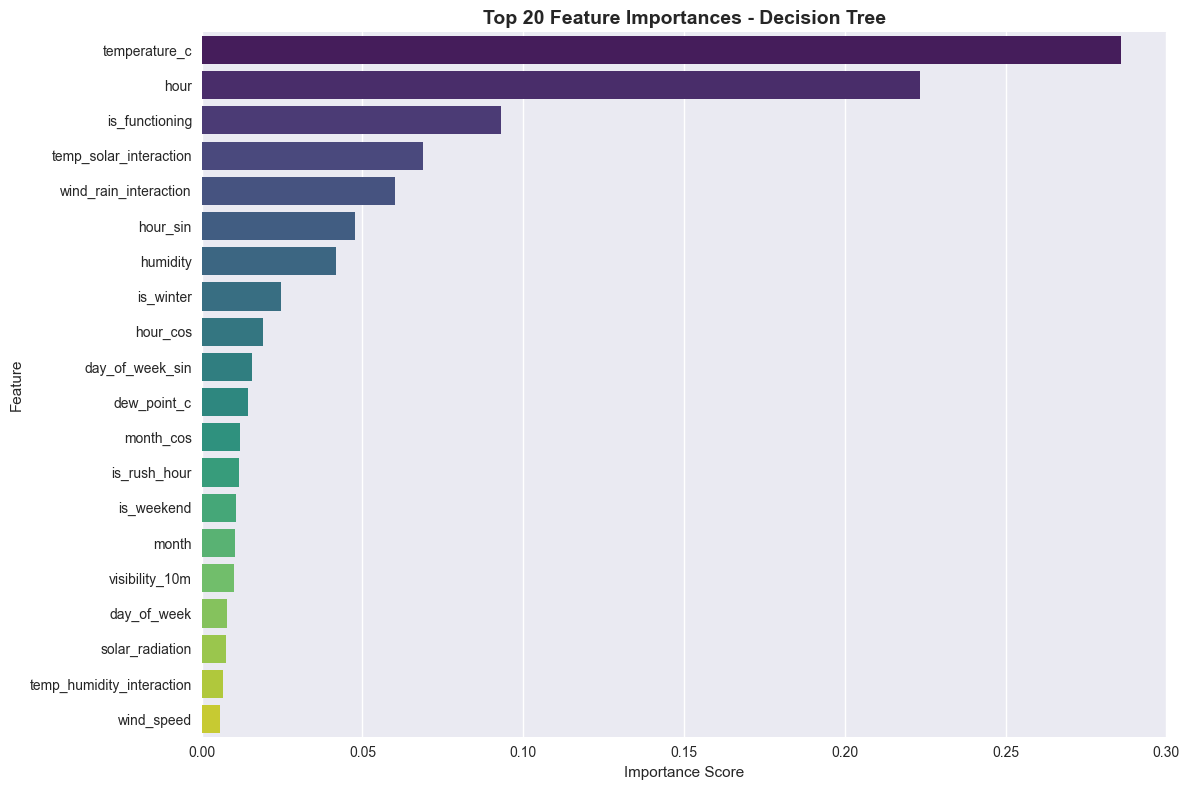


Feature Importance Analysis for Random Forest:


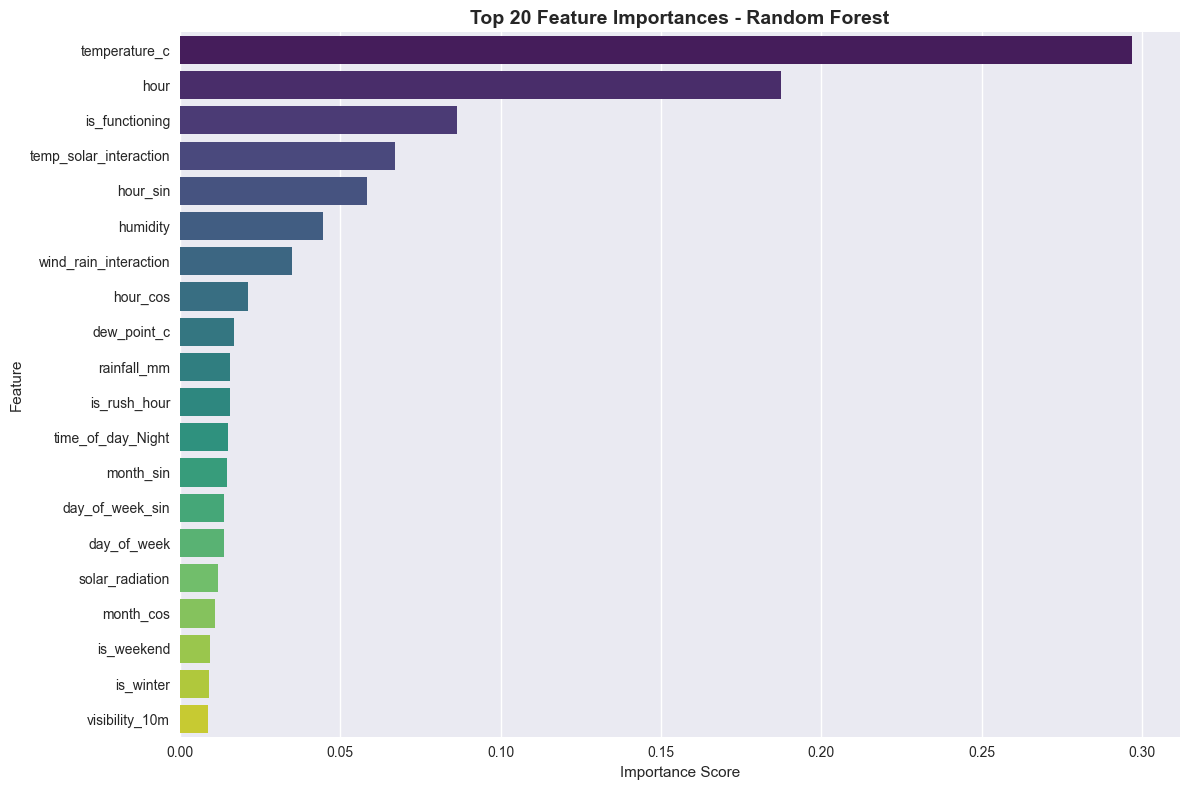


Feature Importance Analysis for Extra Trees:


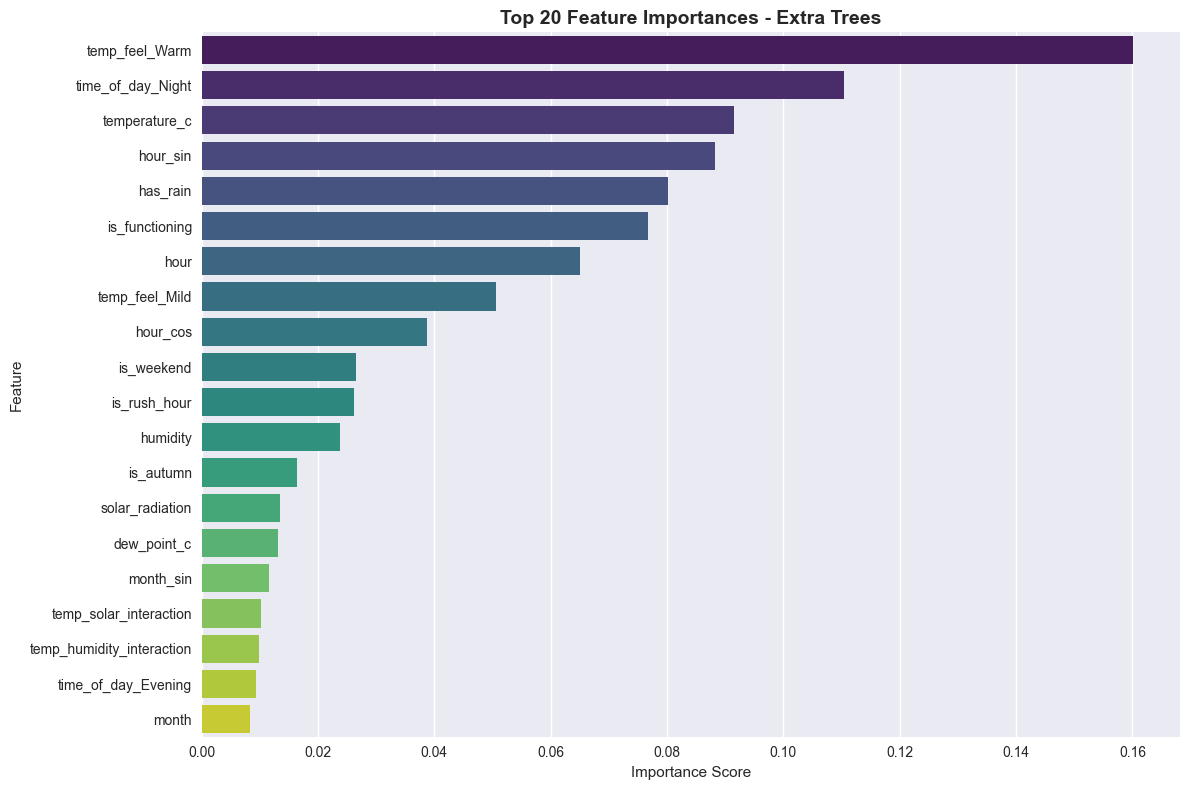


Top 15 Most Important Features for Extra Trees:
          Feature  Importance
   temp_feel_Warm    0.160158
time_of_day_Night    0.110463
    temperature_c    0.091448
         hour_sin    0.088203
         has_rain    0.080128
   is_functioning    0.076663
             hour    0.065057
   temp_feel_Mild    0.050565
         hour_cos    0.038660
       is_weekend    0.026611
     is_rush_hour    0.026192
         humidity    0.023858
        is_autumn    0.016403
  solar_radiation    0.013467
      dew_point_c    0.013138

Feature Importance Analysis for Gradient Boosting:


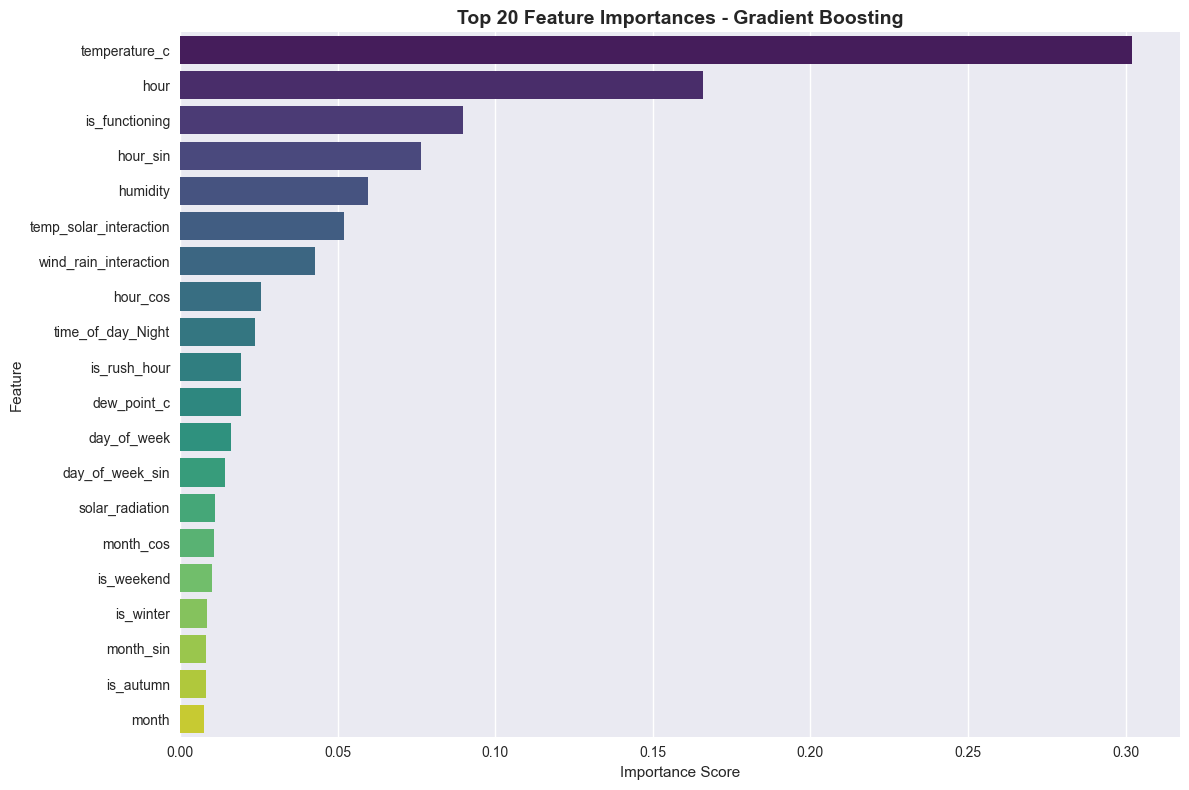

In [23]:
# Analyze feature importance for tree-based models
tree_models = ['Decision Tree', 'Random Forest', 'Extra Trees', 'Gradient Boosting']
best_tree_model_name = None

for model_name in tree_models:
    if model_name in trained_models:
        print(f"\nFeature Importance Analysis for {model_name}:")
        importance_df = analyze_feature_importance(
            trained_models[model_name], feature_names, model_name
        )
        if importance_df is not None and model_name == best_model_name:
            print(f"\nTop 15 Most Important Features for {model_name}:")
            print(importance_df.head(15)[['Feature', 'Importance']].to_string(index=False))
            best_tree_model_name = model_name

In [24]:
def hyperparameter_tuning(X_train, y_train, model_name='Random Forest'):
    """Perform hyperparameter tuning"""
    print(f"Hyperparameter tuning for {model_name}...")
    
    if model_name == 'Random Forest':
        model = RandomForestRegressor(random_state=42, n_jobs=-1)
        param_grid = {
            'n_estimators': [100, 200, 300],
            'max_depth': [10, 15, 20, None],
            'min_samples_split': [2, 5, 10],
            'min_samples_leaf': [1, 2, 4],
            'max_features': ['sqrt', 'log2', None]
        }
    elif model_name == 'Gradient Boosting':
        model = GradientBoostingRegressor(random_state=42)
        param_grid = {
            'n_estimators': [100, 200, 300],
            'max_depth': [3, 5, 7],
            'learning_rate': [0.05, 0.1, 0.15],
            'min_samples_split': [2, 5, 10],
            'min_samples_leaf': [1, 2, 4]
        }
    elif model_name == 'Extra Trees':
        model = ExtraTreesRegressor(random_state=42, n_jobs=-1)
        param_grid = {
            'n_estimators': [100, 200, 300],
            'max_depth': [10, 15, 20, None],
            'min_samples_split': [2, 5, 10],
            'min_samples_leaf': [1, 2, 4],
            'max_features': ['sqrt', 'log2', None]
        }
    else:
        print(f"Tuning not implemented for {model_name}")
        return None
    
    # Use RandomizedSearchCV for faster tuning
    from sklearn.model_selection import RandomizedSearchCV
    
    random_search = RandomizedSearchCV(
        model, param_grid, n_iter=50, cv=5, 
        scoring='neg_mean_squared_error', n_jobs=-1, 
        random_state=42, verbose=1
    )
    
    random_search.fit(X_train, y_train)
    
    print(f"Best parameters: {random_search.best_params_}")
    print(f"Best cross-validation RMSE: {np.sqrt(-random_search.best_score_):.2f}")
    
    return random_search.best_estimator_

In [25]:
if best_model_name in tree_models:
    tuned_model = hyperparameter_tuning(X_train, y_train, best_model_name)
    
    # Evaluate tuned model
    if tuned_model is not None:
        tuned_result = evaluate_model(tuned_model, X_train, X_test, y_train, y_test, 
                                    f"Tuned {best_model_name}")
        print(f"\nTuned Model Performance:")
        for key, value in tuned_result.items():
            if key != 'Model':
                print(f"{key}: {value:.3f}")


Hyperparameter tuning for Extra Trees...
Fitting 5 folds for each of 50 candidates, totalling 250 fits
Best parameters: {'n_estimators': 300, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': None, 'max_depth': None}
Best cross-validation RMSE: 162.96

Tuned Model Performance:
Train_RMSE: 40.664
Test_RMSE: 154.840
Train_MAE: 21.675
Test_MAE: 88.427
Train_R2: 0.996
Test_R2: 0.942
Train_MAPE: inf
Test_MAPE: inf
Overfitting_Score: -114.176


In [26]:
def analyze_predictions(model, X_test, y_test, model_name, scaler=None):
    """Analyze model predictions with comprehensive visualizations"""
    
    # Make predictions
    if scaler is not None and model_name in ['Linear Regression', 'Ridge Regression', 
                                            'Lasso Regression', 'Elastic Net',
                                            'K-Nearest Neighbors', 'Support Vector Regression']:
        X_test_processed = scaler.transform(X_test)
    else:
        X_test_processed = X_test
    
    y_pred = model.predict(X_test_processed)
    
    # Create comprehensive prediction analysis
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    
    # 1. Predicted vs Actual scatter plot
    axes[0, 0].scatter(y_test, y_pred, alpha=0.6, color='blue', s=10)
    axes[0, 0].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
    axes[0, 0].set_xlabel('Actual Bike Count')
    axes[0, 0].set_ylabel('Predicted Bike Count')
    axes[0, 0].set_title(f'{model_name}: Predicted vs Actual')
    
    # Add R² score to the plot
    r2 = r2_score(y_test, y_pred)
    axes[0, 0].text(0.05, 0.95, f'R² = {r2:.3f}', transform=axes[0, 0].transAxes,
                   bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
    
    # 2. Residuals plot
    residuals = y_test - y_pred
    axes[0, 1].scatter(y_pred, residuals, alpha=0.6, color='green', s=10)
    axes[0, 1].axhline(y=0, color='red', linestyle='--')
    axes[0, 1].set_xlabel('Predicted Bike Count')
    axes[0, 1].set_ylabel('Residuals')
    axes[0, 1].set_title(f'{model_name}: Residuals Plot')
    
    # 3. Residuals histogram
    axes[1, 0].hist(residuals, bins=50, alpha=0.7, color='purple', edgecolor='black')
    axes[1, 0].set_xlabel('Residuals')
    axes[1, 0].set_ylabel('Frequency')
    axes[1, 0].set_title('Distribution of Residuals')
    axes[1, 0].axvline(x=0, color='red', linestyle='--')
    
    # 4. Prediction error by actual value ranges
    bins = pd.cut(y_test, bins=10)
    error_by_range = pd.DataFrame({
        'Actual_Range': bins,
        'Absolute_Error': np.abs(residuals)
    }).groupby('Actual_Range')['Absolute_Error'].mean()
    
    axes[1, 1].bar(range(len(error_by_range)), error_by_range.values, alpha=0.7, color='orange')
    axes[1, 1].set_xlabel('Actual Value Ranges')
    axes[1, 1].set_ylabel('Mean Absolute Error')
    axes[1, 1].set_title('Prediction Error by Value Range')
    axes[1, 1].tick_params(axis='x', rotation=45)
    
    plt.tight_layout()
    plt.show()
    
    # Print prediction statistics
    print(f"\nPrediction Analysis for {model_name}:")
    print(f"Mean Absolute Error: {mean_absolute_error(y_test, y_pred):.2f}")
    print(f"Root Mean Square Error: {np.sqrt(mean_squared_error(y_test, y_pred)):.2f}")
    print(f"R² Score: {r2_score(y_test, y_pred):.3f}")
    print(f"Mean Absolute Percentage Error: {np.mean(np.abs((y_test - y_pred) / y_test)) * 100:.2f}%")
    
    return y_pred




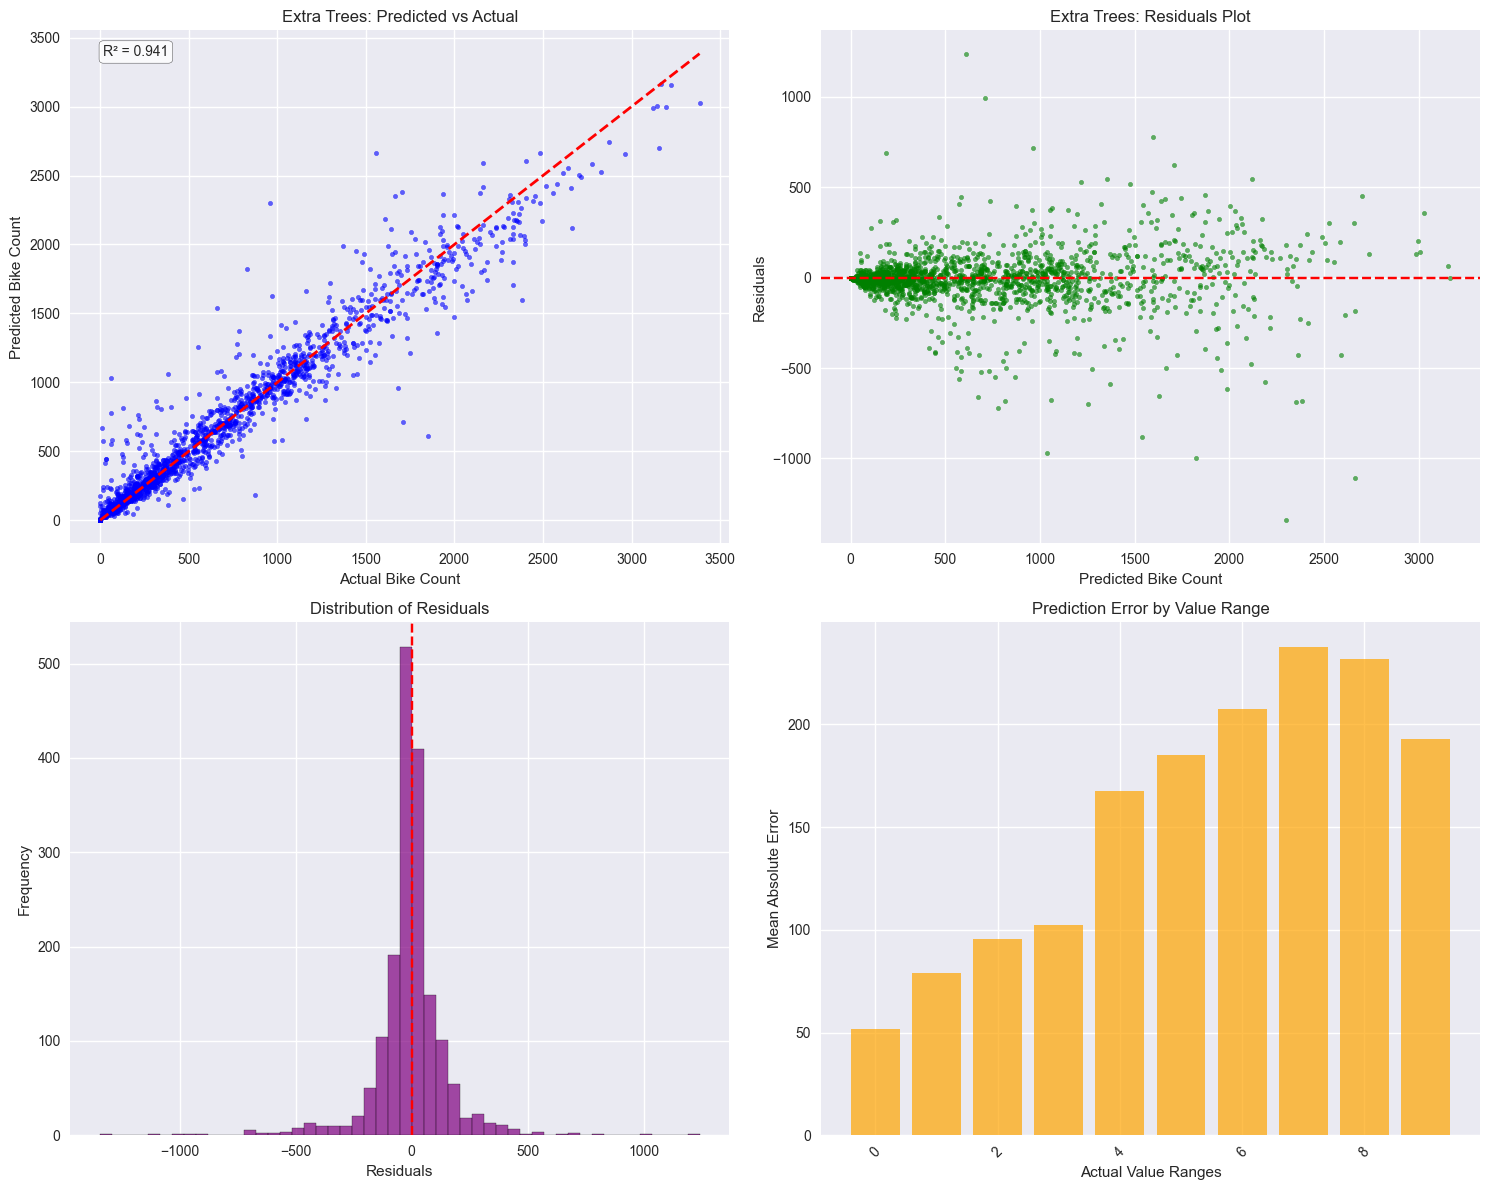


Prediction Analysis for Extra Trees:
Mean Absolute Error: 90.23
Root Mean Square Error: 156.86
R² Score: 0.941
Mean Absolute Percentage Error: inf%


In [27]:
# Analyze predictions for the best model
best_model = trained_models[best_model_name]
y_pred_best = analyze_predictions(best_model, X_test, y_test, best_model_name, scaler)

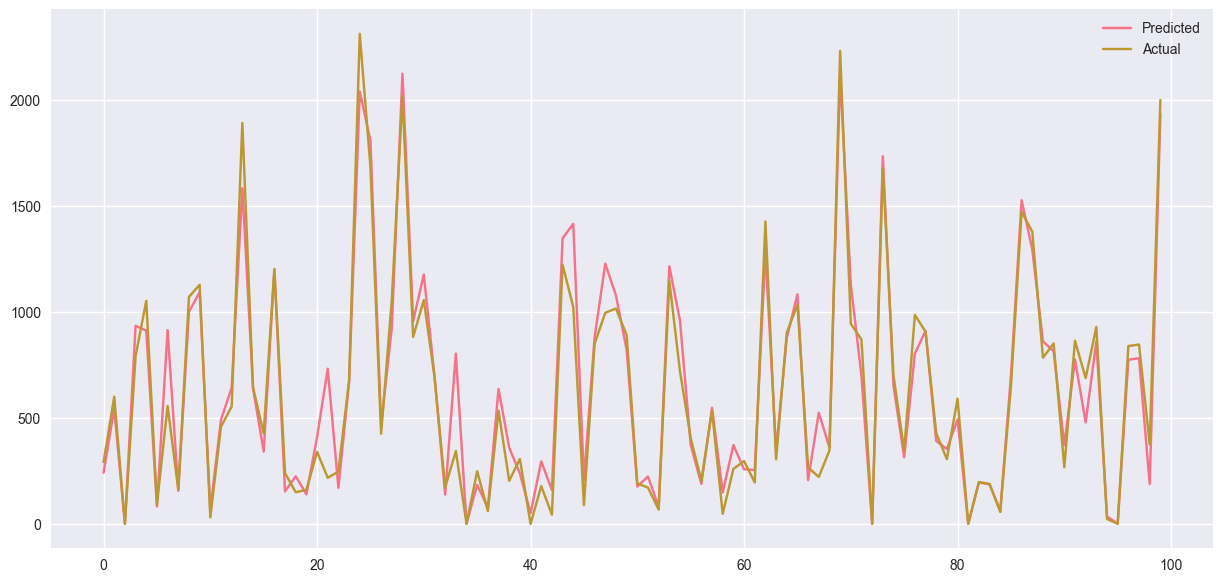

In [38]:
y_pred = best_model.predict(X_test)

plt.figure(figsize=(15,7))
plt.plot((y_pred)[:100])
plt.plot((np.array(y_test)[:100]))
plt.legend(["Predicted","Actual"])
plt.show()

In [35]:
def cross_validation_analysis(models_dict, X, y, cv=5):
    """Perform cross-validation analysis for model stability"""
    cv_results = {}
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    scale_sensitive_models = ['Linear Regression', 'Ridge Regression', 
                             'Lasso Regression', 'Elastic Net', 
                             'K-Nearest Neighbors', 'Support Vector Regression']
    
    for name, model in models_dict.items():
        print(f"Cross-validating {name}...")
        
        if name in scale_sensitive_models:
            cv_scores = cross_val_score(model, X_scaled, y, cv=cv, 
                                      scoring='neg_mean_squared_error', n_jobs=-1)
        else:
            cv_scores = cross_val_score(model, X, y, cv=cv, 
                                      scoring='neg_mean_squared_error', n_jobs=-1)
        
        cv_rmse = np.sqrt(-cv_scores)
        cv_results[name] = {
            'CV_RMSE_Mean': cv_rmse.mean(),
            'CV_RMSE_Std': cv_rmse.std(),
            'CV_RMSE_Min': cv_rmse.min(),
            'CV_RMSE_Max': cv_rmse.max()
        }
    
    return pd.DataFrame(cv_results).T



In [29]:
# Perform cross-validation
print("Performing 5-fold cross-validation...")
cv_results_df = cross_validation_analysis(get_models(), X, y)
print("\nCross-Validation Results (RMSE):")
print(cv_results_df.round(3))

Performing 5-fold cross-validation...
Cross-validating Linear Regression...
Cross-validating Ridge Regression...
Cross-validating Lasso Regression...
Cross-validating Elastic Net...
Cross-validating Decision Tree...
Cross-validating Random Forest...
Cross-validating Extra Trees...
Cross-validating Gradient Boosting...
Cross-validating K-Nearest Neighbors...
Cross-validating Support Vector Regression...

Cross-Validation Results (RMSE):
                           CV_RMSE_Mean  CV_RMSE_Std  CV_RMSE_Min  CV_RMSE_Max
Linear Regression               571.995      118.503      390.922      755.260
Ridge Regression                567.332      115.205      389.065      742.814
Lasso Regression                490.790       80.907      352.360      567.078
Elastic Net                     457.049      116.274      332.850      622.644
Decision Tree                   363.472       60.528      260.246      423.253
Random Forest                   310.674       38.992      257.000      345.939
Extra T